# オッズの予測精度評価
人気順の上位3位が、実際に3位以内に入る可能性のモデルの精度評価。このスコアを超えない限り、オッズ通りに買った方が有利ということになる。

In [33]:
# Resultモデルをデータフレームに変換
import pandas as pd
from datetime import date
ext_dt = date(2015,1,1)
results = Result.objects.filter(race__race_dt__gte=ext_dt, race__result_flg=True).exclude(rank=0).values("rank", "odor")
df = pd.DataFrame.from_records(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157734 entries, 0 to 157733
Data columns (total 2 columns):
odor    157734 non-null int64
rank    157734 non-null int64
dtypes: int64(2)
memory usage: 2.4 MB


In [34]:
import numpy as np

# 目的変数の作成（3位以内ならゼロ、それ以外は1）
df["top3"] = np.where(df["rank"]<=3, 0, 1)
df["odor3"] = np.where(df["odor"]<=3, 0, 1)

# 不要データの削除
df = df.drop("rank", axis=1)
df = df.drop("odor", axis=1)

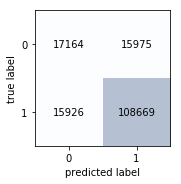

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Confusion Matrixを使った精度評価
cnf_matrix = confusion_matrix(df.top3, df.odor3)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.show()

In [37]:
from sklearn.metrics import recall_score, precision_score
# Uma-Prediction’s evaluation standards for models
# 複勝馬の的中率
recall = round(recall_score(df.top3, df.odor3), 3)
# 購入馬券の的中率
precision = round(precision_score(df.top3, df.odor3), 3)
print("複勝馬の的中率："+str(recall))
print("購入馬券の的中率："+str(precision))

複勝馬の的中率：0.872
購入馬券の的中率：0.872


# サンプル予測モデル構築

In [51]:
# レース結果（2017年1月1日以降で出走結果があり、かつ、出走履歴が３回以上のレース結果）
from datetime import date
import pandas as pd
ext_dt = date(2017,1,1)
results = Result.objects.filter(race__race_dt__gte=ext_dt, race__result_flg=True).exclude(rank=0).values("key", "rank", "sex", "age", "odds", "race__max_prize", "race__head_count", "race__odds_stdev", "race__condition")
df = pd.DataFrame.from_records(results)

# データフレームの整形
df = df.set_index("key")
df = df.rename(columns={"race__max_prize": "race_prize", "race__head_count": "head_count", "race__odds_stdev": "odds_stdev", "race__condition": "condition"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157734 entries, 3回中山2日目 1R-2015102578 to 8回阪神5日目 12R-2006101448
Data columns (total 8 columns):
age           157734 non-null int64
odds          157734 non-null float64
condition     157734 non-null object
head_count    157734 non-null int64
race_prize    157734 non-null float64
odds_stdev    157734 non-null float64
rank          157734 non-null int64
sex           157734 non-null object
dtypes: float64(3), int64(3), object(2)
memory usage: 10.8+ MB


In [52]:

import numpy as np

# 性別データのダミー変数化
dmy_sex = pd.get_dummies(df.sex)
df = pd.concat([df, dmy_sex], axis=1)
df = df.drop("sex", axis=1)
df = df.rename(columns={"セ": "gelding", "牝": "female", "牡": "male"})

# 馬場データのダミー変数化
dmy_condition = pd.get_dummies(df.condition)
df = pd.concat([df, dmy_condition], axis=1)
df = df.drop("condition", axis=1)
df = df.rename(columns={"不良": "soft", "稍重": "good", "良": "firm", "重": "yielding"})

# 目的変数の作成（3位以内ならゼロ、それ以外は1）
df["top3"] = np.where(df["rank"]<=3, 0, 1)

# 不要データの削除
df = df.drop("rank", axis=1)

# データ確認
df.head(10)

,age,odds,head_count,race_prize,odds_stdev,gelding,female,male,soft,good,firm,yielding,top3
key,,,,,,,,,,,,,
3回中山2日目 1R-2015102578,3,8.9,16,500.0,81.29,0,1,0,0,1,0,0,0
3回中山2日目 1R-2015103403,3,187.6,16,500.0,81.29,0,1,0,0,1,0,0,0
3回中山2日目 1R-2015100599,3,5.3,16,500.0,81.29,0,1,0,0,1,0,0,0
3回中山2日目 1R-2015105711,3,4.8,16,500.0,81.29,0,1,0,0,1,0,0,1
3回中山2日目 1R-2015106131,3,3.5,16,500.0,81.29,0,1,0,0,1,0,0,1
3回中山2日目 1R-2015102949,3,31.3,16,500.0,81.29,0,1,0,0,1,0,0,1
3回中山2日目 1R-2015100351,3,8.4,16,500.0,81.29,0,1,0,0,1,0,0,1
3回中山2日目 1R-2015103294,3,85.0,16,500.0,81.29,0,1,0,0,1,0,0,1
3回中山2日目 1R-2015102412,3,130.6,16,500.0,81.29,0,1,0,0,1,0,0,1


In [53]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータの分離
X = df.drop("top3", axis=1)
y = df.top3
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [54]:
# 学習（時間がかかります）
from sklearn.svm import SVC
svm = SVC(class_weight="balanced")
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

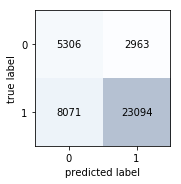

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Confusion Matrixを使った精度評価
y_pred = svm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.show()

In [58]:
from sklearn.metrics import recall_score, precision_score
# Uma-Prediction’s evaluation standards for models
# 複勝馬の的中率
recall = round(recall_score(y_test, y_pred), 2)
# 購入馬券の的中率
precision = round(precision_score(y_test, y_pred), 2)
print("複勝馬の的中率："+str(recall))
print("購入馬券の的中率："+str(precision))

複勝馬の的中率：0.74
購入馬券の的中率：0.89
